In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import duckdb
import polars as pl
import altair as alt
import pandas as pd
import pyarrow as pa
import os
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import textwrap
import re

In [3]:
import sys
sys.path.append('../databasing')
import databasing_utils as db_utils

# Initialize DuckDB database with Sleep+Autonomic data

In [7]:
db_path = '/media/shortterm_ssd/Clay/databases/duckdb/rcs-db.duckdb'
con = duckdb.connect(database=db_path)

In [1]:
os.listdir('/media/shortterm_ssd/Clay/databases/Sleep_10day_with_autonomic/')

['RCS03R',
 'RCS09R',
 'RCS07L',
 'RCS07R',
 'RCS09L',
 'RCS16R',
 'RCS02R',
 'RCS02L',
 'RCS16L',
 'RCS03L']

In [8]:
def label_and_import_parquets(base_path, cols_to_drop):
    devices = os.listdir(base_path)
    for device in devices:
        device_file_path = base_path + device + '/Overnight/'
        device_identifier = device[3:]
        
        ind = 0
        for session_parquet in glob.glob(device_file_path + '/*.parquet'):
            df = pl.read_parquet(session_parquet)
            df = df.drop(cols_to_drop)
            
            end_date = pl.select(df[df.height-1,['localTime']])[0,0].date().strftime('%m-%d-%y')
            session_classifier = device_identifier + '_' + end_date

            session_num = os.path.split(session_parquet)[1].split("_")[0]
            df = df.with_column(pl.lit(session_num).alias('Session#'))
            df = df.with_column(pl.lit(session_classifier).alias('SessionIdentity'))

            if not 'TD_key1' in df.columns:
                df = df.drop(['Power_Band3', 'Power_Band4'])
                df = df.rename({'TD_key0': 'TD_BG'})
            elif not 'TD_key0' in df.columns:
                df = df.drop(['Power_Band1', 'Power_Band2'])
                df = df.rename({'TD_key1': 'TD_BG', 'Power_Band3': 'Power_Band1', 'Power_Band4': 'Power_Band2'})
                print(f"For {session_parquet} recasted TD_key1 as TD_BG and Power Bands 3 and 4 as 1 and 2, respectively.")

            df_arrow = df.to_arrow()
            if ind == 0:
                con.execute(f"CREATE OR REPLACE TABLE overnight.r{device_identifier} AS SELECT * FROM df_arrow")
            else:
                con.execute(f"INSERT INTO overnight.r{device_identifier} SELECT * FROM df_arrow")
            ind += 1

In [48]:
cols_to_drop = [
 'PO_infrared_filtered',
 'PO_infrared_raw',
 'PO_red_filtered',
 'PO_red_raw',
 'positiongram',
 'PulseOxyInfrared',
 'RespirationX',
 'RespirationY',
 'RespirationZ'
 ]

base_path = '/media/shortterm_ssd/Clay/databases/Sleep_10day_with_autonomic/'

label_and_import_parquets(base_path, cols_to_drop)

In [54]:
con.execute("DESCRIBE;")
con.fetchall()

[('r02L',
  ['Accel_XSamples',
   'Accel_YSamples',
   'Accel_ZSamples',
   'Accel_samplerate',
   'DerivedTime',
   'Power_Band1',
   'Power_Band2',
   'Power_Band5',
   'Power_Band6',
   'Power_Band7',
   'Power_Band8',
   'Power_IsPowerChannelOverrange',
   'Session#',
   'SessionIdentity',
   'SleepStage',
   'TD_BG',
   'TD_key2',
   'TD_key3',
   'localTime'],
  ['DOUBLE',
   'DOUBLE',
   'DOUBLE',
   'DOUBLE',
   'DOUBLE',
   'DOUBLE',
   'DOUBLE',
   'DOUBLE',
   'DOUBLE',
   'DOUBLE',
   'DOUBLE',
   'DOUBLE',
   'VARCHAR',
   'VARCHAR',
   'DOUBLE',
   'DOUBLE',
   'DOUBLE',
   'DOUBLE',
   'TIMESTAMP WITH TIME ZONE'],
  False),
 ('r02L_eventlogs',
  ['EventName',
   'EventSubType',
   'EventType',
   'HostUnixTime',
   'SessionId',
   'UnixOffsetTime',
   'UnixOnsetTime'],
  ['VARCHAR', 'VARCHAR', 'VARCHAR', 'BIGINT', 'BIGINT', 'BIGINT', 'BIGINT'],
  False),
 ('r02R',
  ['Accel_XSamples',
   'Accel_YSamples',
   'Accel_ZSamples',
   'Accel_samplerate',
   'DerivedTime',
   '

## Create sorted view of each overnight table

In [6]:
devices = con.sql('select table_name from information_schema.tables where table_schema = \'overnight\';').fetchall()
con.close()

for device in devices:
    device = device[0]
    table_name = f'overnight.{device}'
    db_utils.create_sorted_view(table_name, 'DerivedTime', db_path)
    

## TODO: SET PRIMARY KEYS - localTime and DerivedTime

# Insert Settings Tables into DuckDB

In [10]:
con = duckdb.connect(database='/media/shortterm_ssd/Clay/databases/duckdb/rcs-db.duckdb')

In [11]:
def label_and_import_settings_csvs(base_path, cols_to_drop=None, replace=False):
    devices = os.listdir(base_path)
    for device in devices:
        device_file_path = base_path + device
        
        ind = 0
        for setting_csv in glob.glob(device_file_path + '/*.csv'):
            df = pl.read_csv(setting_csv)
            if cols_to_drop:
                df = df.drop(cols_to_drop)

            df_arrow = df.to_arrow()
            settings_type = re.split('[_ / .]', setting_csv)[-2]

            con.execute(f"create schema if not exists r{device[3:]};")
            if replace:
                con.execute(f"create or replace table r{device[3:]}.{settings_type} as select * from df_arrow;")
            else:
                con.execute(f"create table if not exists r{device[3:]}.{settings_type} as select * from df_arrow limit 0;")
                con.execute(f"insert into r{device[3:]}.{settings_type} select * from df_arrow;")

In [12]:
label_and_import_settings_csvs('/media/longterm_hdd/Clay/Sleep_10day_with_autonomic/', replace=True)

In [13]:
con.execute('select * from r02L.FftAndPowerSettings').pl().columns

['Session#',
 'SessionStartTime',
 'SessionEndTime',
 'SessionTypes',
 'Device',
 'SessionIdentity',
 'recNum',
 'duration',
 'timeStart',
 'timeStop',
 'TDsampleRates',
 'Power_Band1',
 'Power_Band2',
 'Power_Band3',
 'Power_Band4',
 'Power_Band5',
 'Power_Band6',
 'Power_Band7',
 'Power_Band8',
 'Power_Band1_indices',
 'Power_Band2_indices',
 'Power_Band3_indices',
 'Power_Band4_indices',
 'Power_Band5_indices',
 'Power_Band6_indices',
 'Power_Band7_indices',
 'Power_Band8_indices',
 'Power_Band1_bins',
 'Power_Band2_bins',
 'Power_Band3_bins',
 'Power_Band4_bins',
 'Power_Band5_bins',
 'Power_Band6_bins',
 'Power_Band7_bins',
 'Power_Band8_bins',
 'fft_bandFormationConfig',
 'fft_config',
 'fft_interval',
 'fft_size',
 'fft_streamOffsetBins',
 'fft_numBins',
 'fft_windowLoad',
 'fft_binWidth']

In [14]:
con.execute("DESCRIBE;")
con.fetchall()

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

[('AdaptiveSettings',
  ['Session#',
   'Session#',
   'Session#',
   'Session#',
   'Session#',
   'Session#',
   'Session#',
   'Session#',
   'Session#',
   'Session#',
   'SessionStartTime',
   'SessionStartTime',
   'SessionStartTime',
   'SessionStartTime',
   'SessionStartTime',
   'SessionStartTime',
   'SessionStartTime',
   'SessionStartTime',
   'SessionStartTime',
   'SessionStartTime',
   'SessionEndTime',
   'SessionEndTime',
   'SessionEndTime',
   'SessionEndTime',
   'SessionEndTime',
   'SessionEndTime',
   'SessionEndTime',
   'SessionEndTime',
   'SessionEndTime',
   'SessionEndTime',
   'SessionTypes',
   'SessionTypes',
   'SessionTypes',
   'SessionTypes',
   'SessionTypes',
   'SessionTypes',
   'SessionTypes',
   'SessionTypes',
   'SessionTypes',
   'SessionTypes',
   'Device',
   'Device',
   'Device',
   'Device',
   'Device',
   'Device',
   'Device',
   'Device',
   'Device',
   'Device',
   'SessionIdentity',
   'SessionIdentity',
   'SessionIdentity',
  

In [ ]:
con.close()

# Simple sanity plots with Seaborn

In [5]:
power_df = con.execute("Select columns('^Power_Band') from overnight.r02L where Power_Band1 is not NULL").df()

In [ ]:
devices = ['02L', '02R', '03L', '03R', '07L', '07R', '09L', '09R', '16L', '16R']
power_df = con.execute(f"Select columns('^Power_Band') from overnight.r{devices[0]} where Power_Band1 is not NULL").df()

In [ ]:
g = sns.PairGrid(power_df)
g.map(sns.scatterplot)
g.fig.suptitle(devices[0])
plt.show()

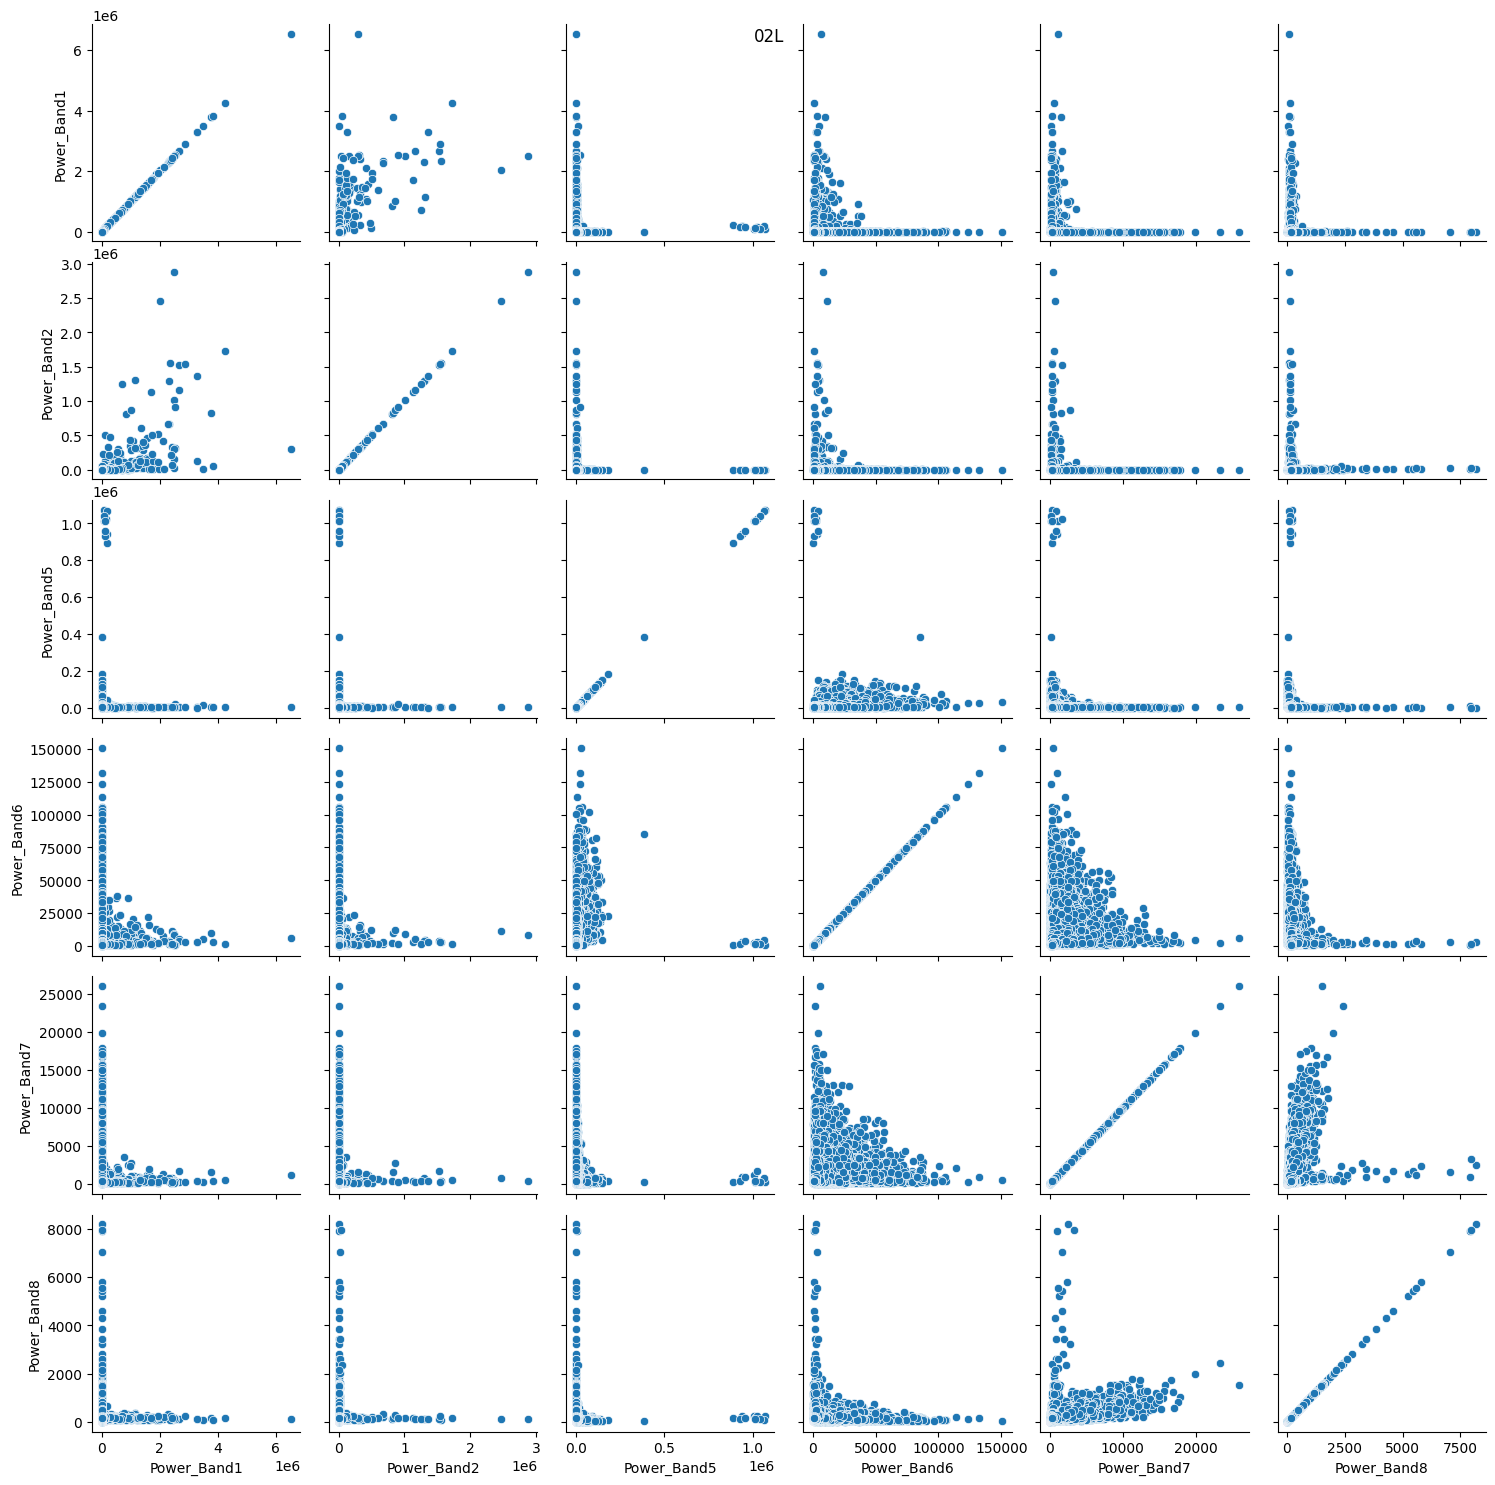

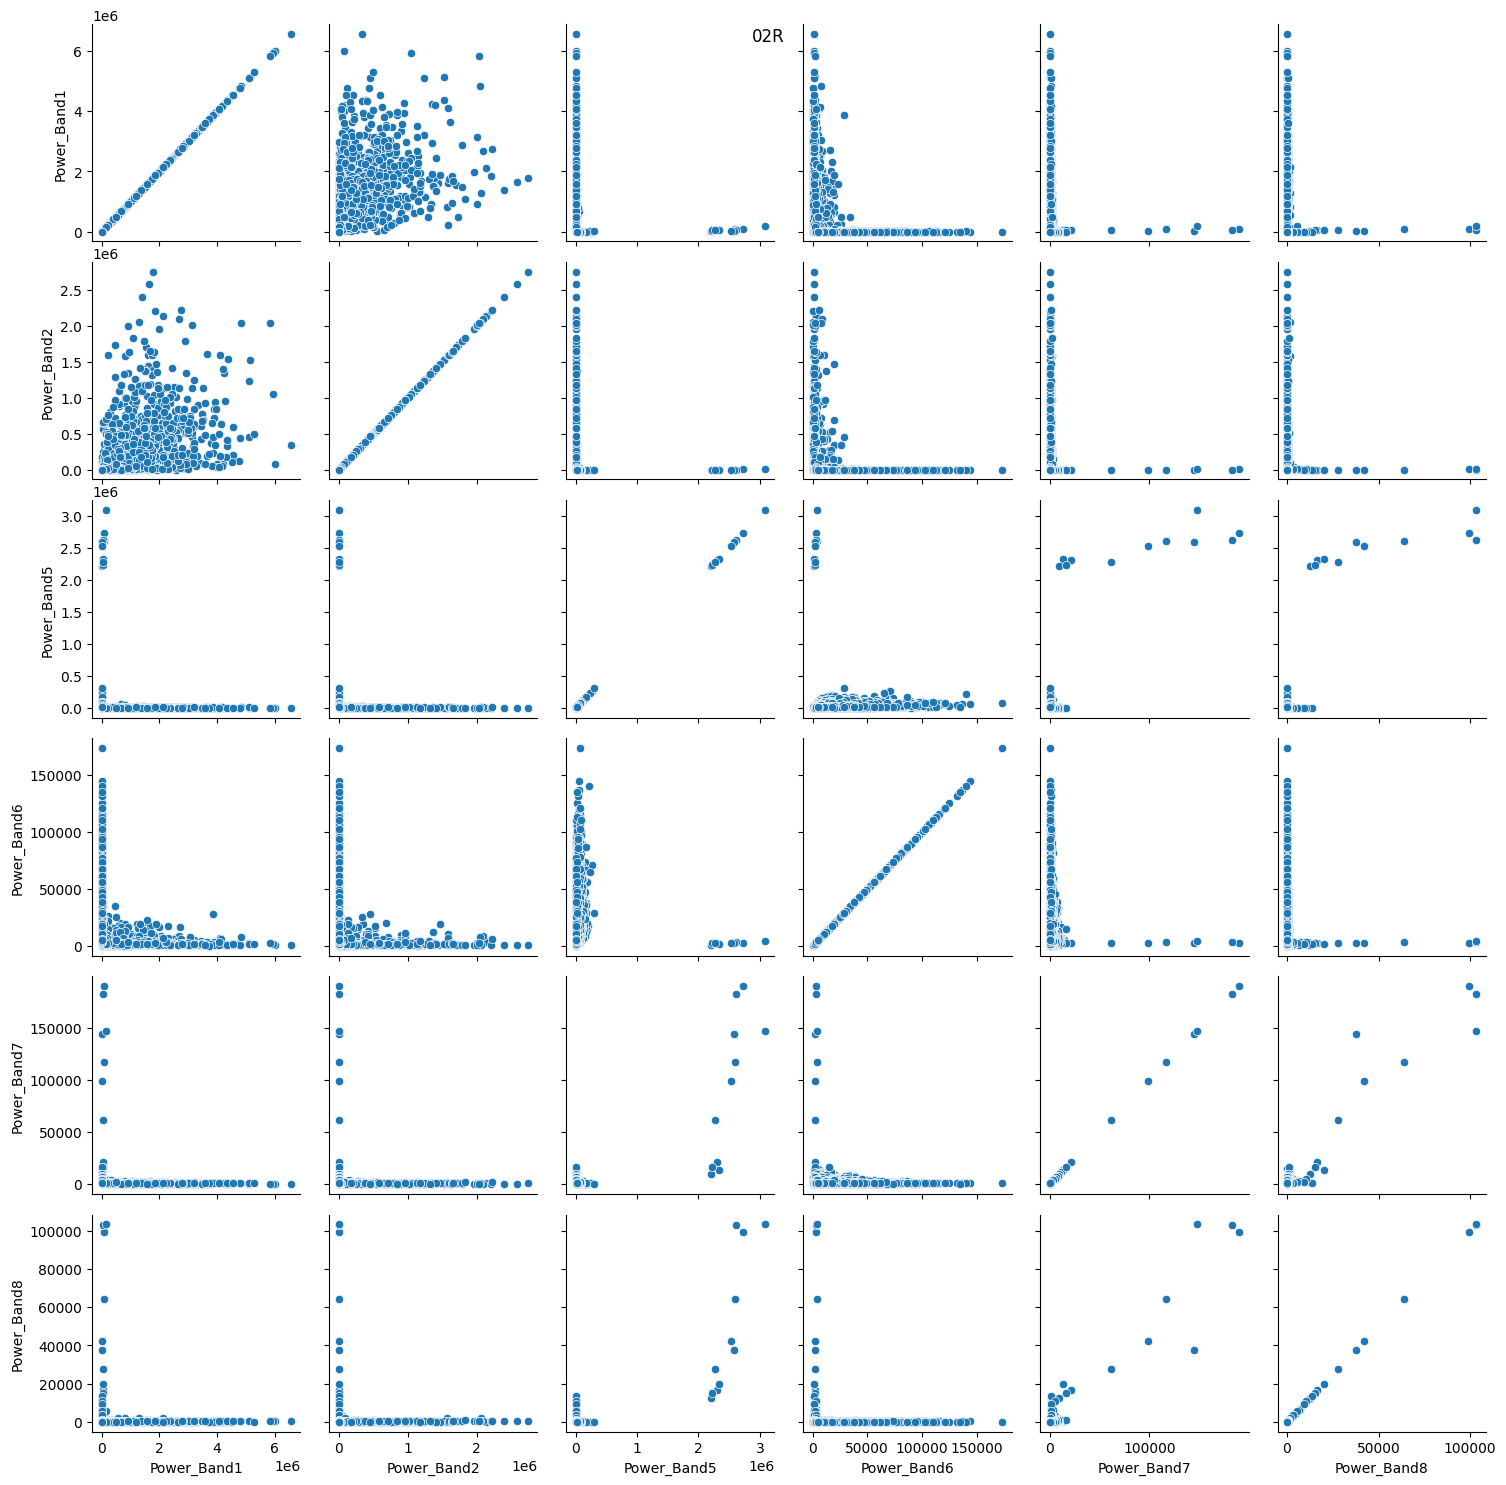

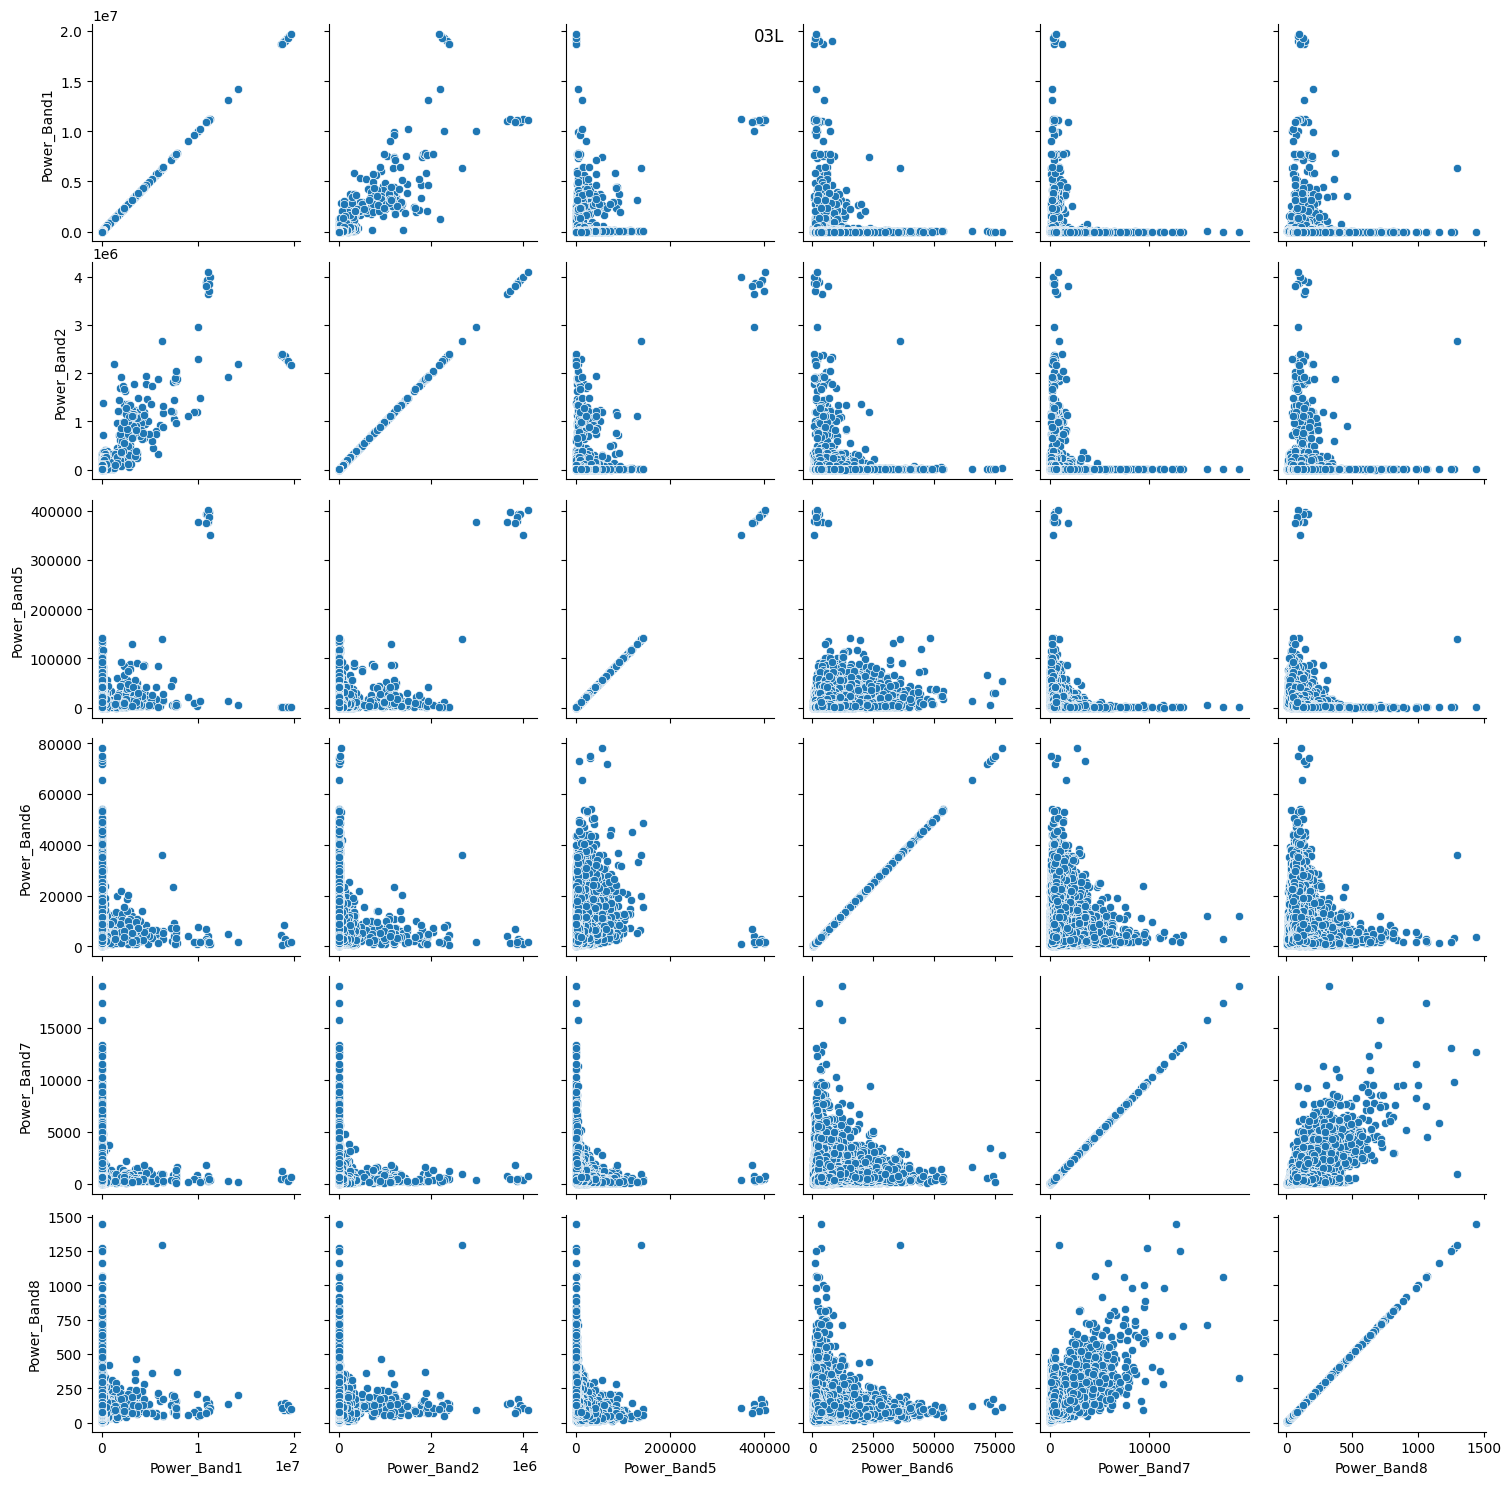

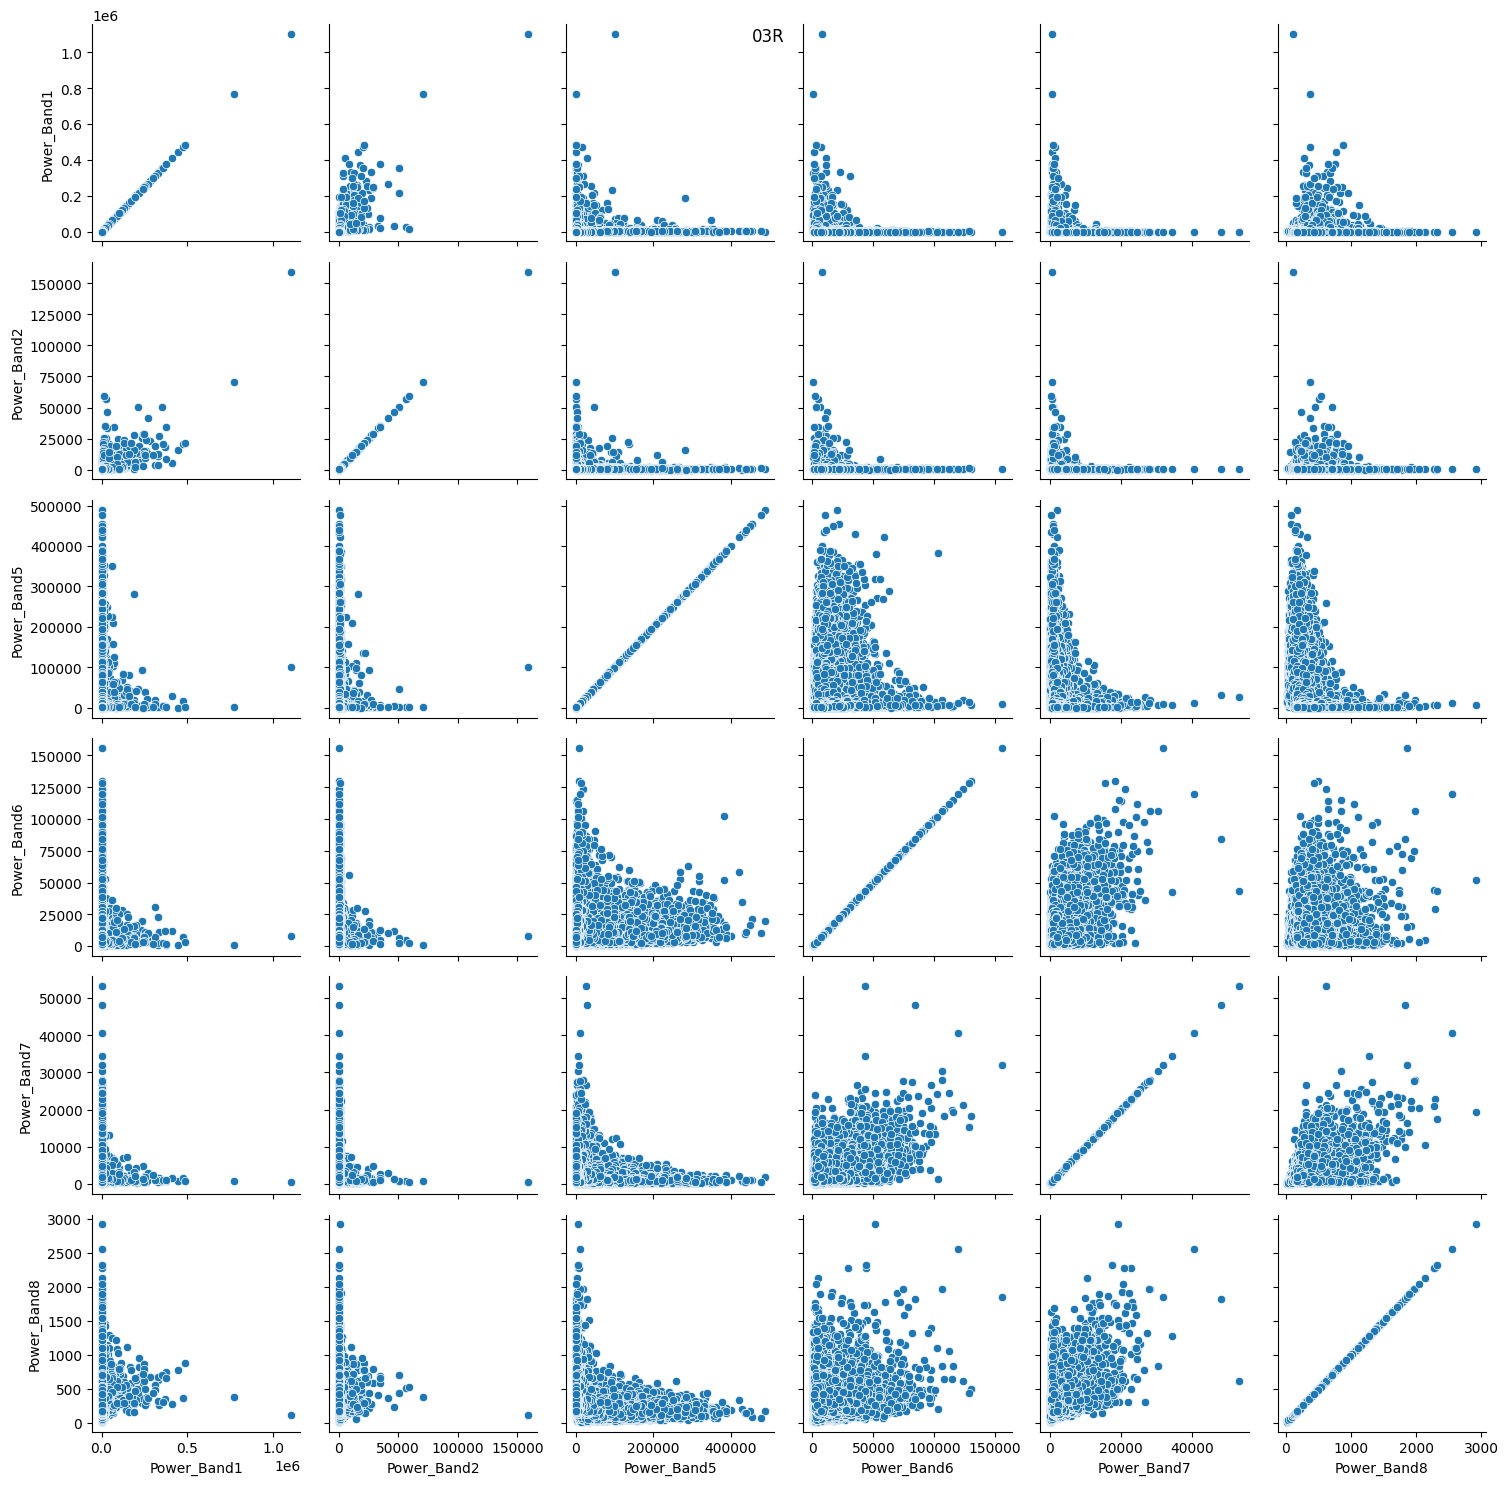

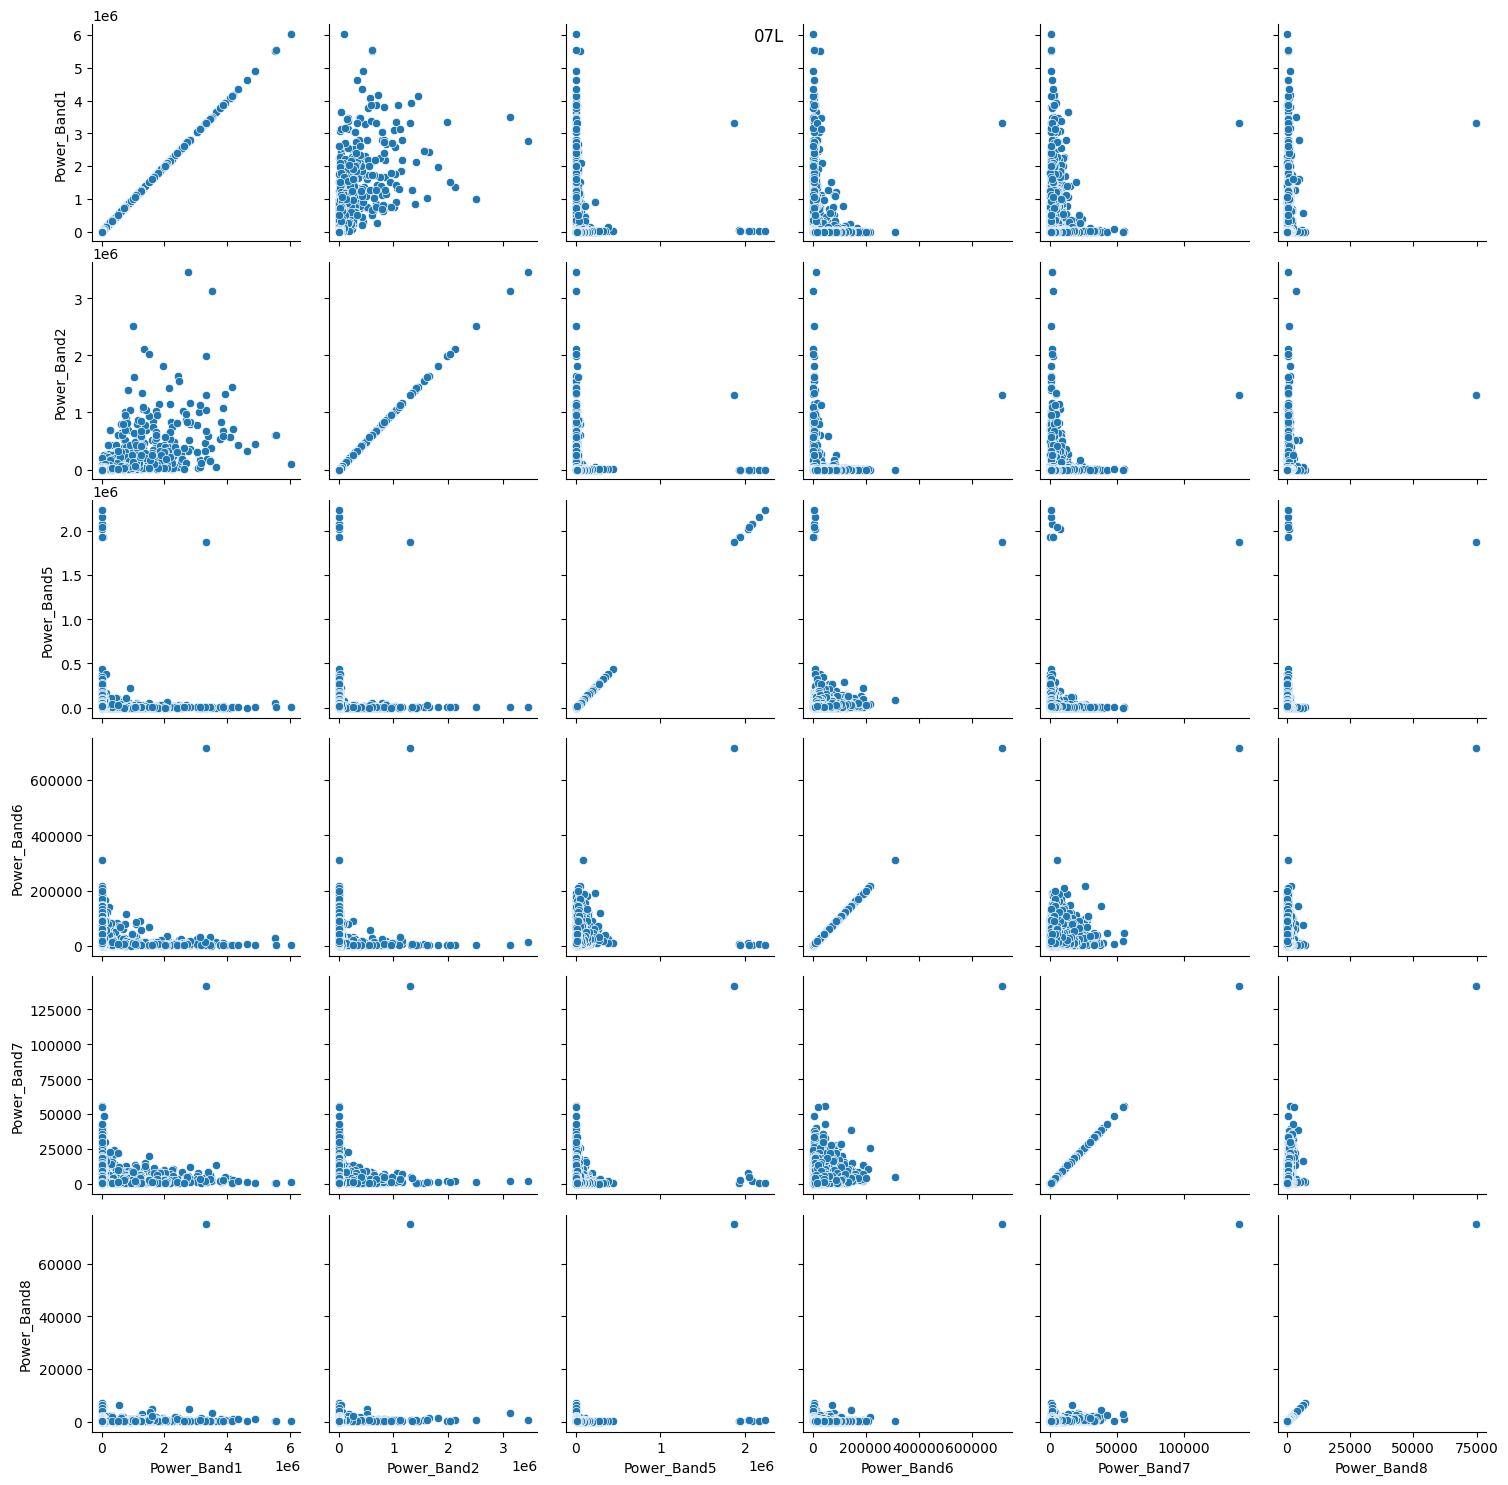

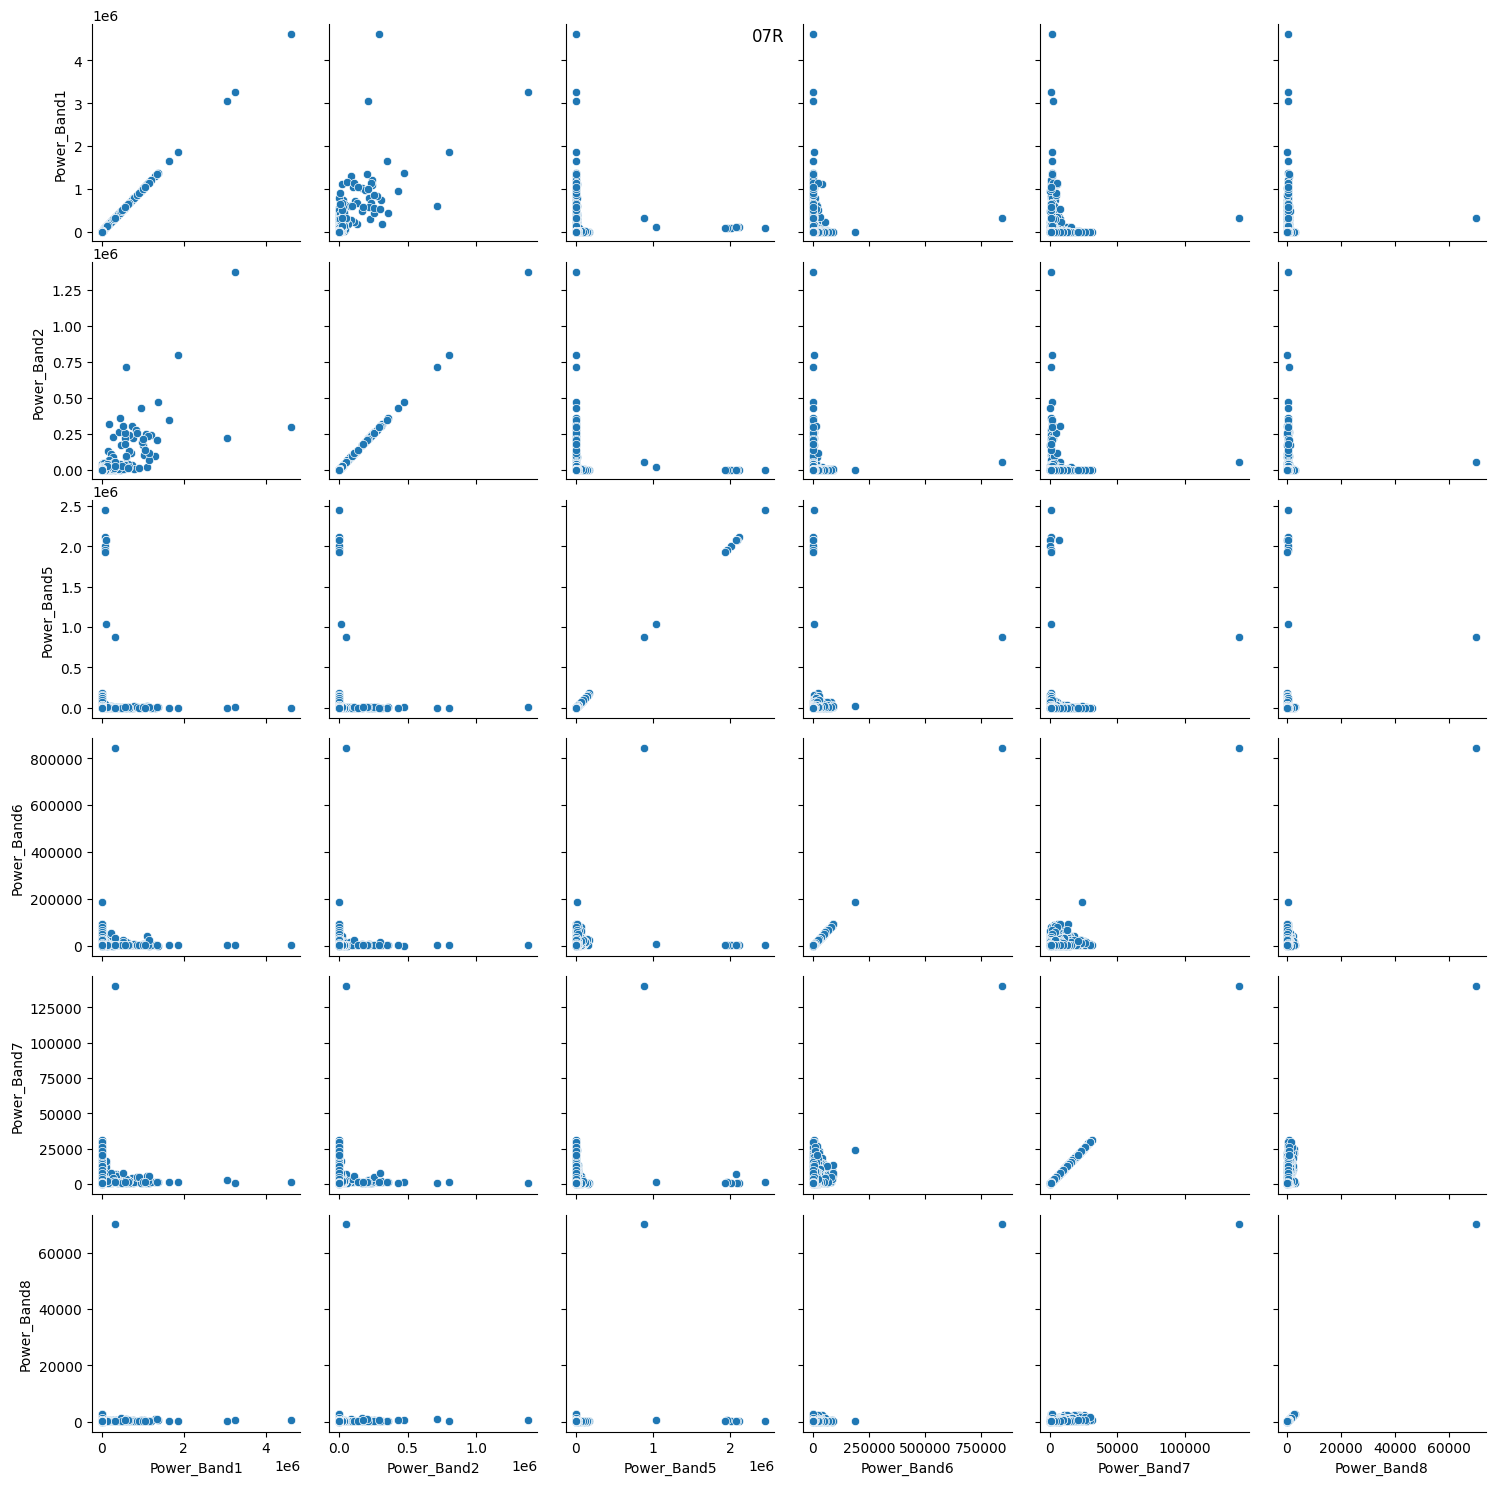

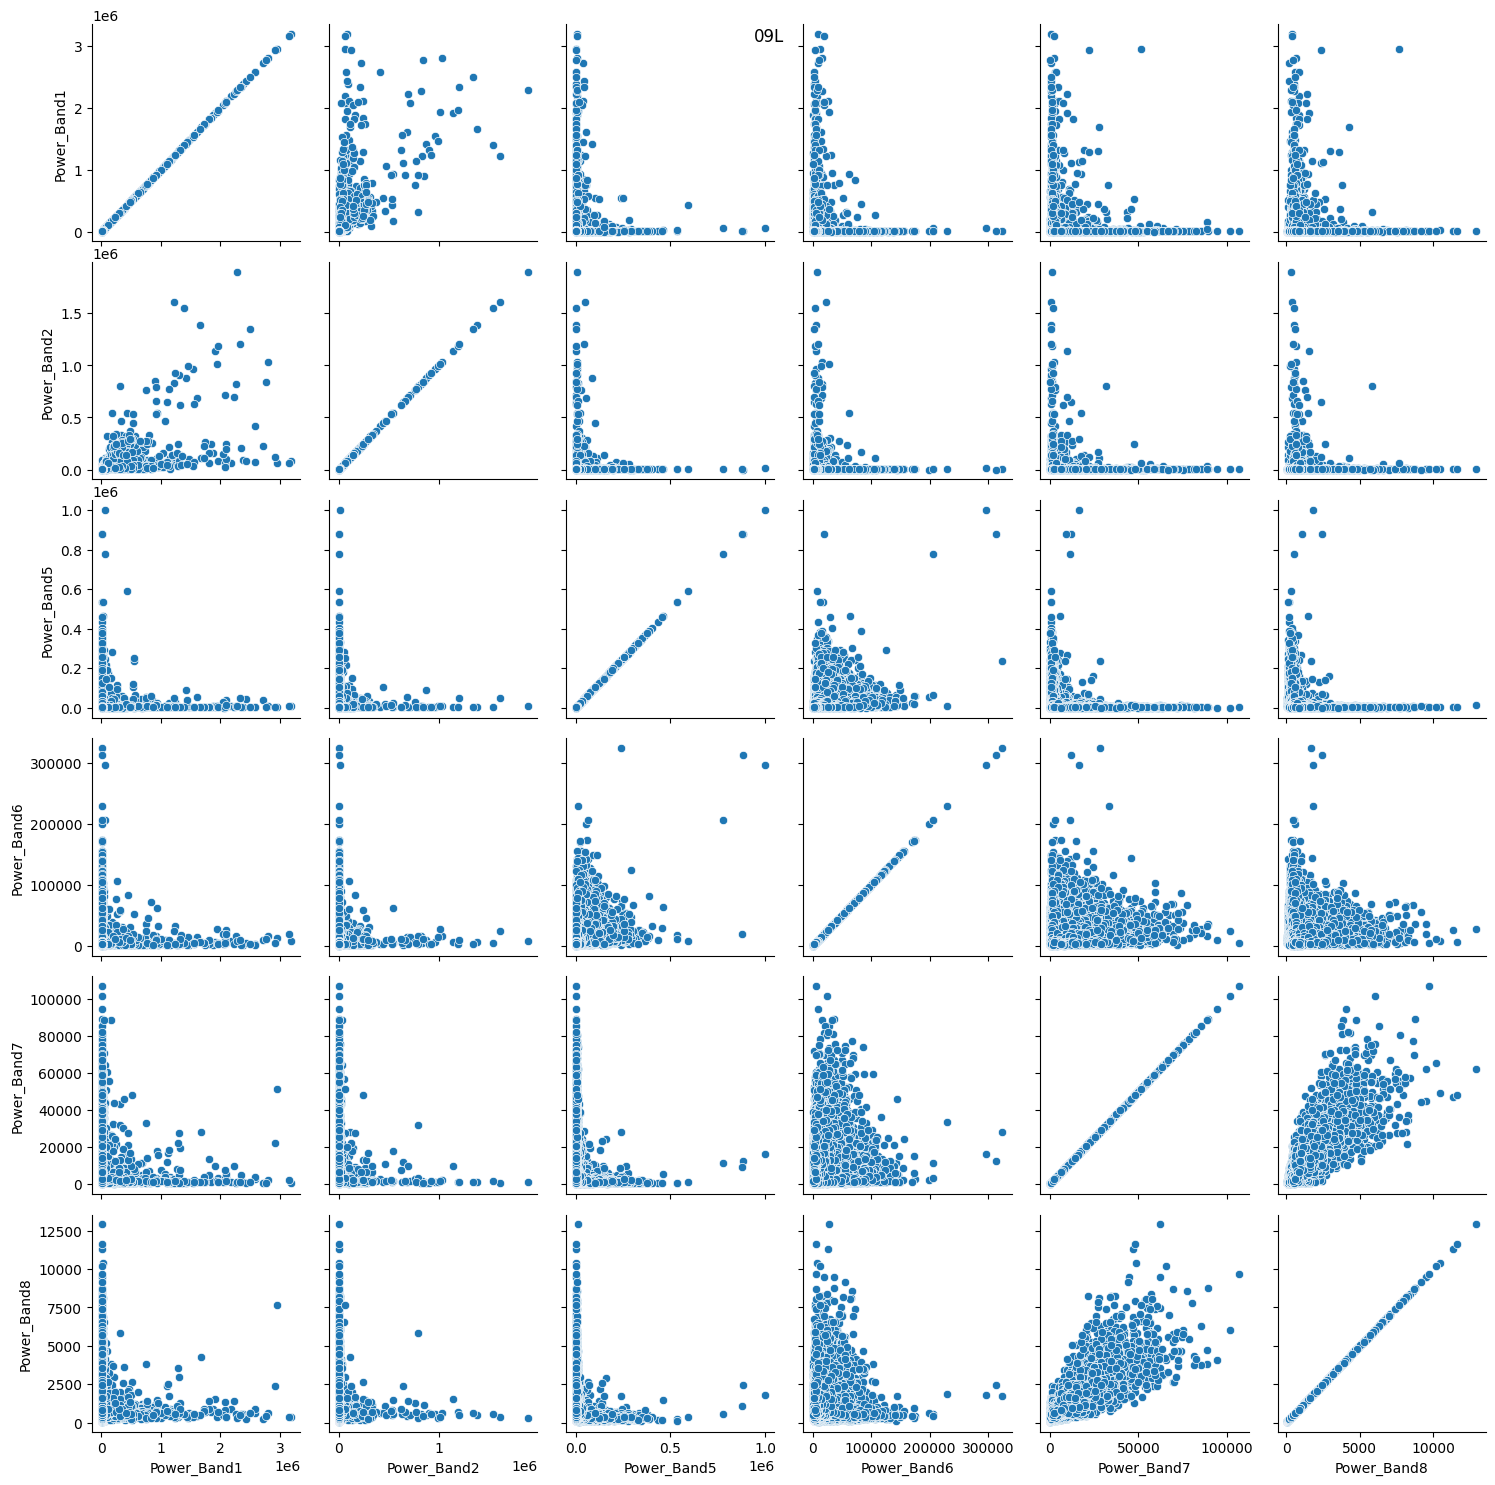

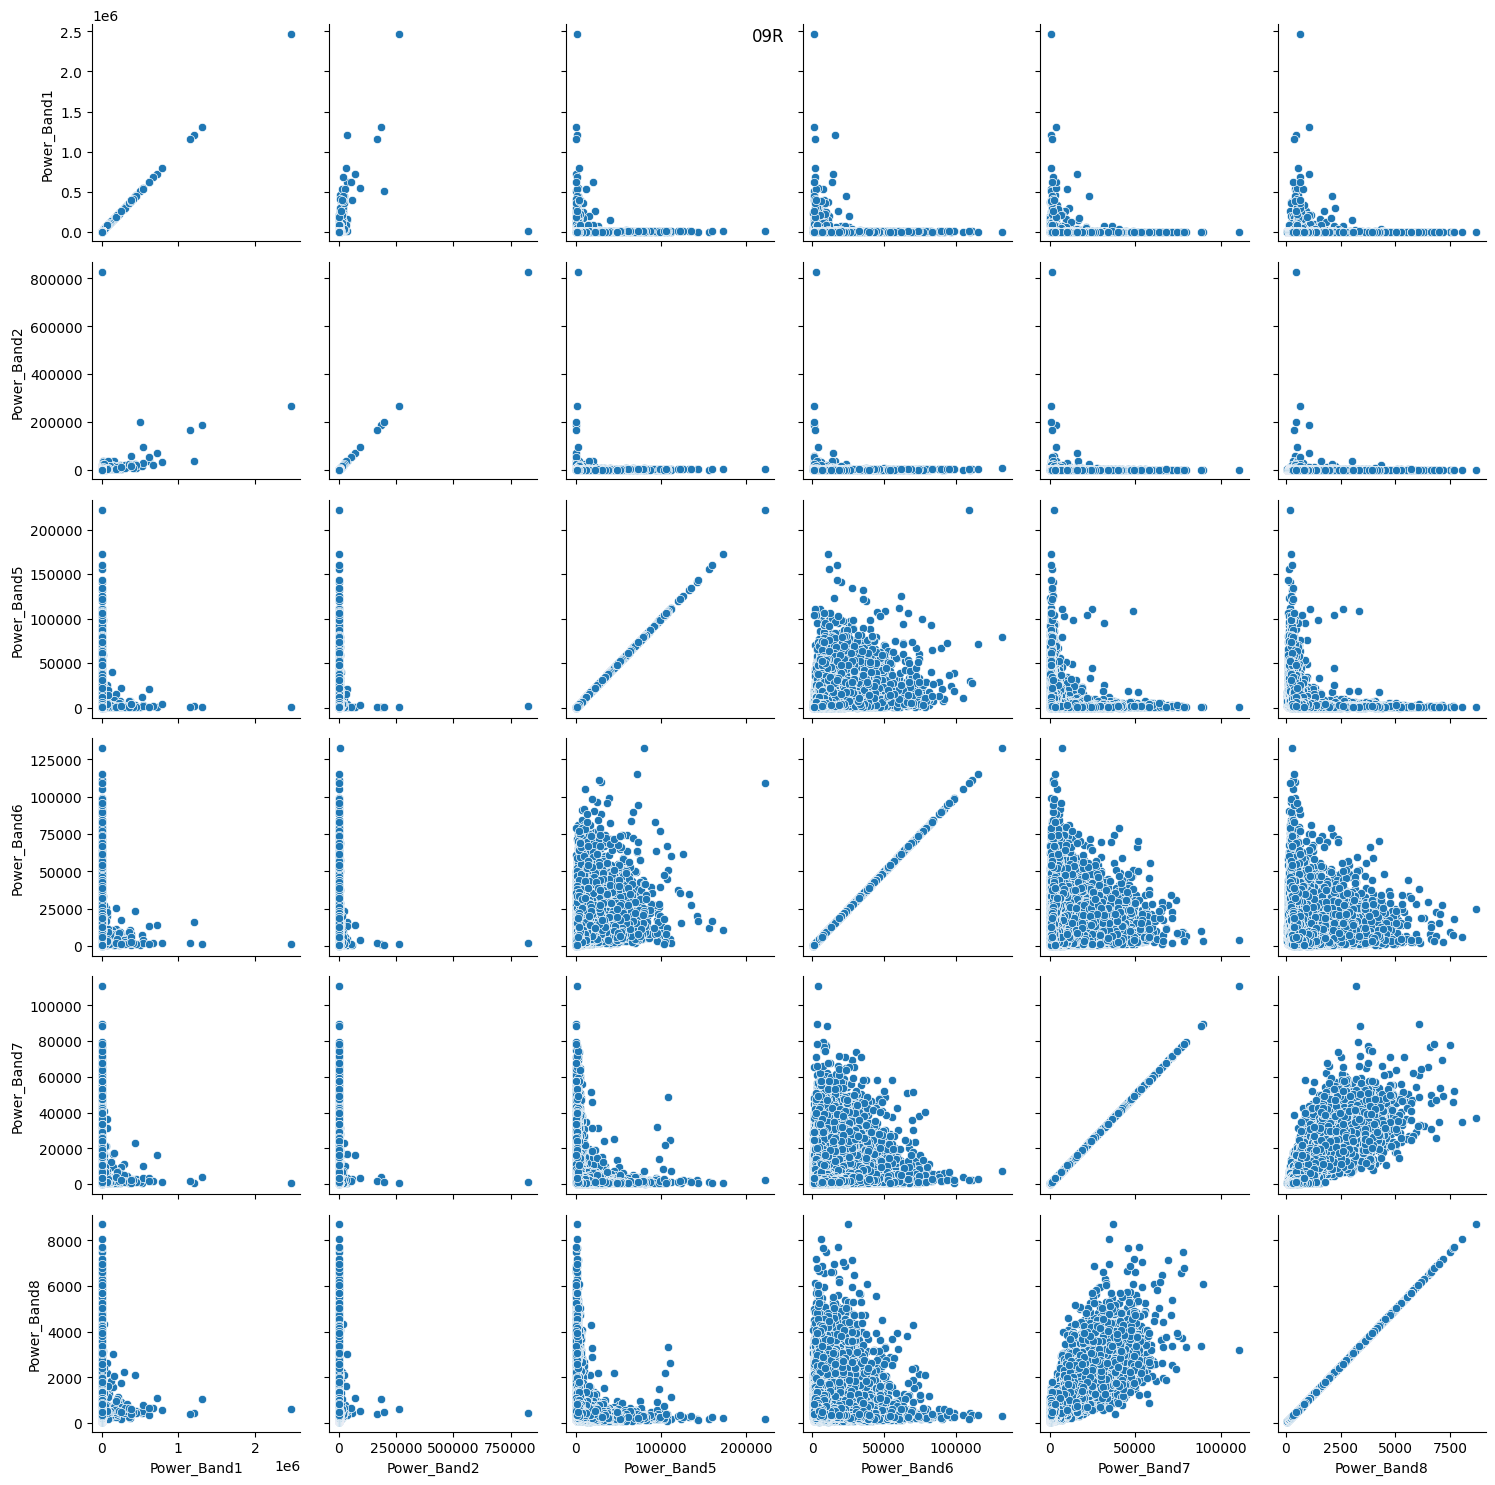

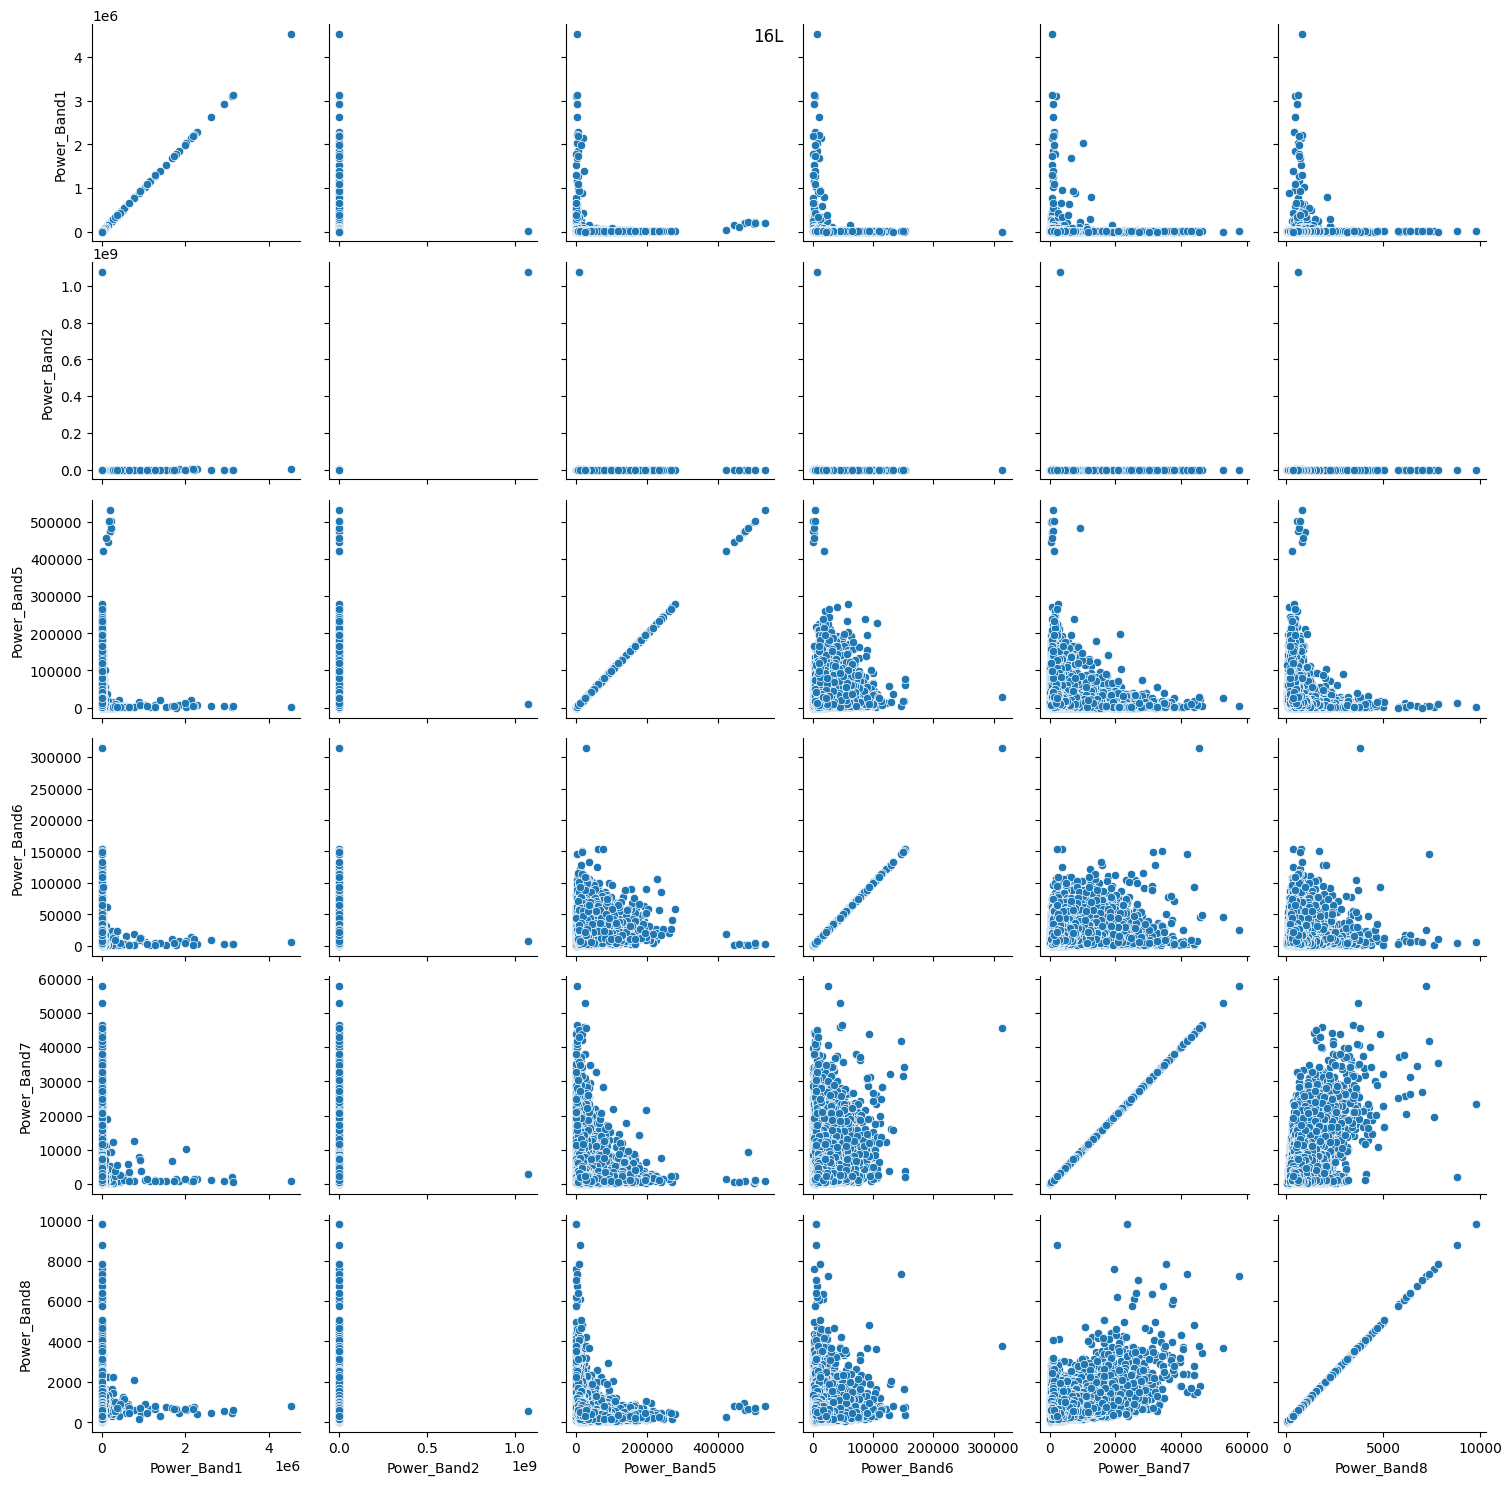

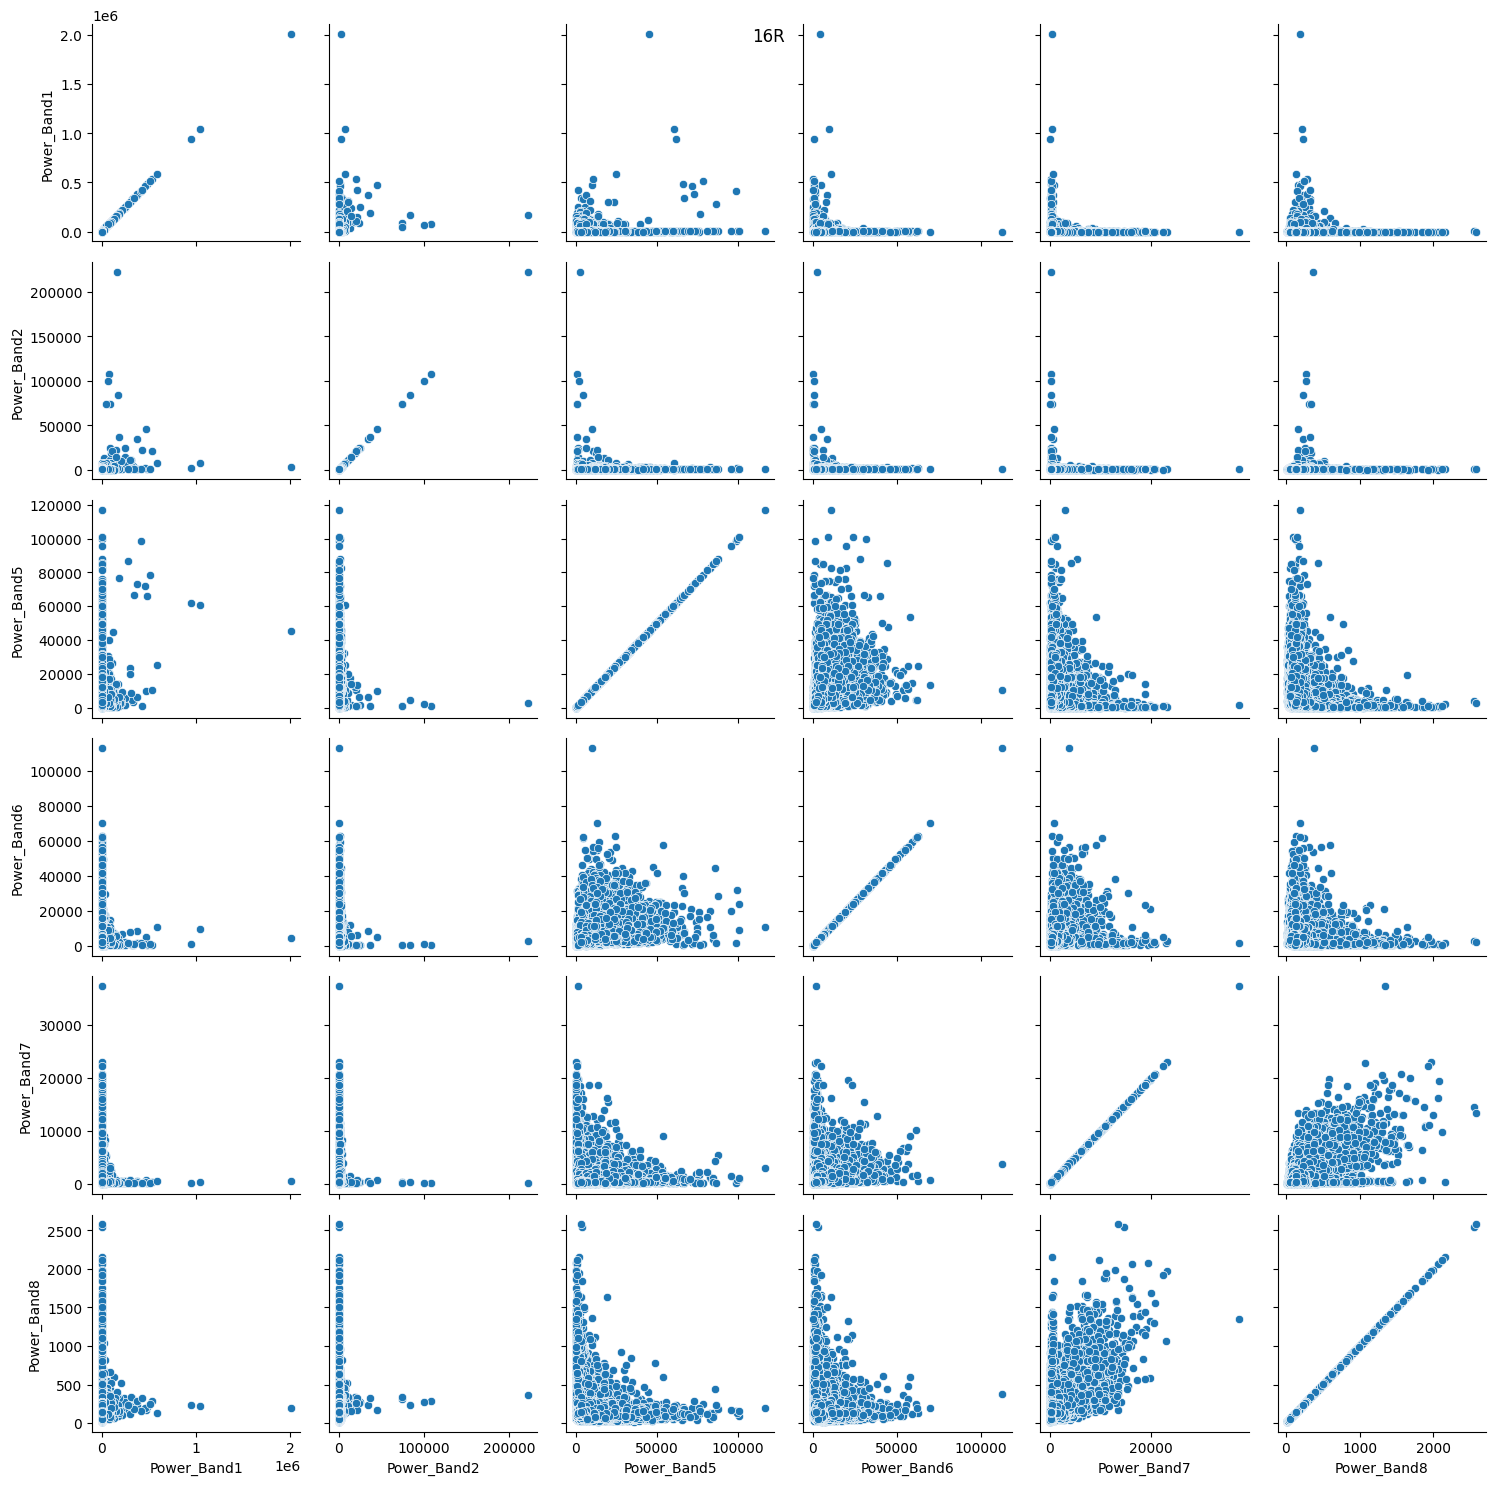

In [27]:
devices = ['02L', '02R', '03L', '03R', '07L', '07R', '09L', '09R', '16L', '16R']
for device in devices:
    power_df = con.execute(f"Select columns('^Power_Band') from overnight.r{device} where Power_Band1 is not NULL").df()
    g = sns.PairGrid(power_df)
    g.map(sns.scatterplot)
    g.fig.suptitle(device)
    plt.show()
